In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.v2 as v2
import torchvision.transforms.functional as F
from torchvision.tv_tensors import Image, Mask
from tqdm import tqdm

In [2]:
from google.colab import drive

# 드라이브 마운트
# drive.mount('/content/drive')

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


5. 추가 실습(심화)
    - 심화 문제는 채점에 포함되지 않습니다. 편한 마음으로 도전해 보세요.

    1. 미션 소개
        - 목표: 조건부 GAN(cGAN)을 활용하여 다양한 모자 이미지를 생성하는 모델을 구축합니다.
        - 데이터셋:
            - 해당 데이터셋은 20개 클래스(각기 다른 스타일의 모자, 캡, 헬멧 등)로 구성되어 있습니다.
            - 이미지의 해상도와 다양성이 FashionMNIST보다 높으므로, 모델 구조나 학습 전략을 조금 더 세밀하게 조정해야 할 수 있습니다.
    2. 실습 내용
        1. 데이터 로드 및 전처리
            - ImageFolder 등으로 데이터를 불러오고, 적절한 크기로 리사이즈합니다.
            - 데이터 증강 기법(예: Random Crop, Horizontal Flip, Color Jitter 등)을 적용해 데이터 다양성을 확보합니다.
        2. 모델 설계 및 학습
            - 기존의 FashionMNIST cGAN 모델을 베이스로 하되, 이미지 해상도와 데이터 복잡성을 고려하여 Generator와 Discriminator의 네트워크 구조를 조정해 보세요.
            - 조건부 레이블을 사용하여 각 모자 클래스에 따른 이미지를 생성하도록 학습시키세요.
        3. 평가 및 결과 시각화
            - 학습 도중 및 학습 후에 각 클래스별로 생성된 이미지를 시각화하여, 모델의 성능을 평가해 보세요.
            - 다양한 평가 지표를 활용해 모델의 개선 방향을 모색해 보세요.
        4. 마크다운 설명
            - 각 단계의 의도와 알고리즘, 구현 방법 등을 상세히 기록해 주세요.
            - 실험 결과 및 개선 방안에 대한 해설이나 인사이트를 포함해도 좋습니다.
    3. 제출 안내 (추가 실습)
        - 추가 실습에 대한 결과도 포함된 Notebook 파일을 제출해 주세요.
        - 미션을 시작할 때 도움이 필요하다면, Baseline 코드를 참고할 수 있습니다. 이 코드는 기본적인 코드로 제공되며, 여러분이 원하는 대로 자유롭게 변형할 수 있어요.

# 1.Baseline

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/headgear-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/headgear-image-classification/versions/1


In [4]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


# 데이터 변환 설정 (훈련 데이터: 증강 포함)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 크기 조정
    transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전 (50% 확률)
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # 색상변화(약하게)
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # -1 ~ 1 범위 정규화 (cGAN 학습 최적화)
])

# 검증 및 테스트 데이터 변환 (증강 X)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 원본 데이터셋
train_dataset = datasets.ImageFolder(root=os.path.join(path, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(path, "valid"), transform=test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(path, "test"), transform=test_transform)

# DataLoader 설정 (배치 크기 32, 셔플링 적용)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 클래스 정보 확인
class_to_idx = train_dataset.class_to_idx  # 클래스 이름과 인덱스 매핑
idx_to_class = {v: k for k, v in class_to_idx.items()}  # 인덱스로 클래스명 찾기

# 데이터셋 크기 출력
print(f"Train set size: {len(train_dataset)}")
print(f"Valid set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Classes: {list(class_to_idx.keys())}")

Train set size: 3620
Valid set size: 100
Test set size: 100
Classes: ['ASCOT CAP', 'BASEBALL CAP', 'BERET', 'BICORNE', 'BOATER', 'BOWLER', 'DEERSTALKER', 'FEDORA', 'FEZ', 'FOOTBALL HELMET', 'GARRISON CAP', 'HARD HAT', 'MILITARY HELMET', 'MOTARBOARD', 'PITH HELMET', 'PORK PIE', 'SOMBERO', 'SOUTHWESTER', 'TOP HAT', 'ZUCCHETTO']


이미지 배치 크기: torch.Size([32, 3, 128, 128])
레이블 배치 크기: torch.Size([32])


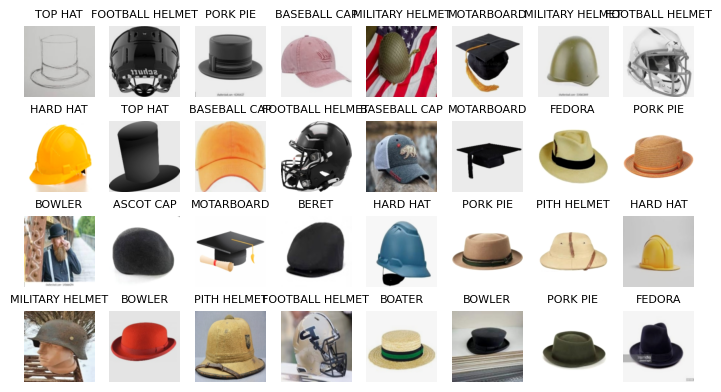

In [5]:
# 배치 크기 확인
images, labels = next(iter(train_loader))
print(f"이미지 배치 크기: {images.size()}")
print(f"레이블 배치 크기: {labels.size()}")

# 증강 시각화
n_row = 4
n_col = 8
plt.figure(figsize=(7, 4))
for i in range(len(images)):
    plt.subplot(n_row, n_col, i + 1)
    # 정규화 해제
    images[i] = images[i] * 0.5 + 0.5
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f"{idx_to_class[labels[i].item()]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

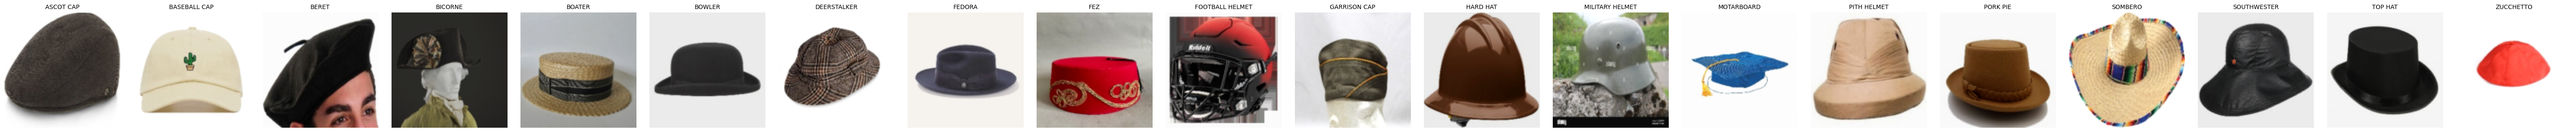

In [6]:
# 각 클래스별로 한 개씩 샘플을 저장할 딕셔너리 생성
class_samples = {}

for img, label in train_dataset:
    if label not in class_samples:
        class_samples[label] = img
    # 모든 클래스에 대한 샘플이 수집되면 종료
    if len(class_samples) == len(class_to_idx):
        break

# 클래스 수만큼 subplot 생성
num_classes = len(class_samples)
fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 3, 3))

# 각 클래스별로 저장된 이미지를 시각화
for label in range(num_classes):
    # 이미지 텐서: (C, H, W) -> (H, W, C)
    img = class_samples[label].permute(1, 2, 0).numpy()
    # 정규화 해제: (img * std + mean) mean=0.5, std=0.5이므로 [0,1] 범위로 변환
    img = img * 0.5 + 0.5
    axs[label].imshow(img)
    axs[label].axis('off')
    axs[label].set_title(idx_to_class[label], fontsize=10)

plt.tight_layout()
plt.show()

1. 노이즈 벡터 크기 (latent_dim) 변경
    - 기존: 100 → 변경: 128
    - 더 높은 차원의 노이즈 벡터를 사용하여 생성된 이미지의 다양성 증가.
2. Generator의 클래스 임베딩 크기 변경
    - 기존: num_classes → 변경: num_classes // 2
    - 최근 연구에서 임베딩 차원을 줄이면 성능이 향상된다고 보고됨.
3. Generator의 업샘플링 방식 변경
    - 기존: ConvTranspose2d (DCGAN 방식)
    - 변경: Upsample + Conv2d
    - Checkerboard Artifact 방지 및 이미지 품질 개선.
4. Discriminator의 lable_fc 방식 추가
    - 기존 : num_classes를 바로 concat
    - 변경 : MLP + concat 방식 사용
5. Discriminator의 label_input 처리 방식 변경
    - 기존: expand() → 변경: repeat()
    - expand()는 역전파 오류 발생 가능, repeat()을 사용하여 안정적인 학습 가능.
6. BatchNorm → Spectral Normalization 적용
    - 기존: BatchNorm2d → 변경: Spectral Normalization
    - Spectral Normalization을 사용하면 판별자의 학습이 더욱 안정적으로 진행됨.
7. Discriminator의 마지막 Sigmoid() 제거
    - 기존: Sigmoid() 포함 → 변경: 제거
    - BCEWithLogitsLoss를 사용하므로, Sigmoid()는 불필요하며 제거 시 수치적으로 더 안정적인 학습 가능.
8. Label Smoothing 적용
    - 기존: real = torch.ones(current_batch_size, 1)
    - 변경: real = torch.full((current_batch_size, 1), 0.9)
    - label smoothing을 적용하여 학습 안정성 향상

In [7]:
# 하이퍼파라미터 설정
latent_dim = 128  # 노이즈 벡터 크기 변경 (100 -> 128)
num_classes = len(class_to_idx)  # 데이터셋의 클래스 개수
image_size = 128  # 이미지 크기

# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 클래스 숫자에서 절반으로 감소(최근 논문은 줄어드는 것이 더 효과적이라고 발표)
        self.label_emb = nn.Embedding(num_classes, num_classes // 2)

        self.init_size = image_size // 16  # 128/16 = 8
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes // 2, 512 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        # 4번의 업샘플링 블록을 사용하여 8->16->32->64->128의 해상도로 만들기
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2, mode='nearest'),    # 8 -> 16
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),    # 16 -> 32
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),    # 32 -> 64
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),    # 64 -> 128
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_input = self.label_emb(labels)
        x = torch.cat([z, label_input], dim=1)
        out = self.l1(x)
        out = out.view(x.size(0), 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 클래스 숫자에서 절반으로 감소(최근 논문은 줄어드는 것이 더 효과적이라고 발표)
        self.label_emb = nn.Embedding(num_classes, num_classes // 2)

        # 레이블 결합 방식 최적화 (MLP + concat 방식 사용)
        self.label_fc = nn.Linear(num_classes // 2, 64)    # 레이블을 64 변환

        # BatchNorm 대신 Spectral Normalization 적용
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(3 + 64, 64, kernel_size=4, stride=2, padding=1)),  # 67 -> 64 (64채널 추가)
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),  # 64 -> 32
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),  # 32 -> 16
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)),  # 16 -> 8
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)),  # 8 -> 4
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.adv_layer = nn.Linear(1024 * 4 * 4, 1)     # BCEWithLogitsLoss 사용 / Sigmoid제거

    def forward(self, img, labels):
        # 레이블을 이미지 크기에 맞게 변환 후 concat 방식 적용
        label_input = self.label_fc(self.label_emb(labels)).view(-1, 64, 1, 1)  # (batch, 64, 1, 1)
        label_input = label_input.repeat(1, 1, image_size, image_size)          # (batch, 64, 128, 128)
        d_in = torch.cat((img, label_input), dim=1)     # 레이블 별도 채널 추가
        out = self.model(d_in)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity

In [8]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

num_epochs = 300  # 훈련 횟수
criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# 학습 루프 (label smoothing 적용)
for epoch in range(num_epochs):
    # 학습
    generator.train()
    discriminator.train()

    # 지표 계산용 변수
    running_d_loss = 0.0
    running_g_loss = 0.0
    d_x_total = 0.0
    d_gz_total = 0.0
    total_samples = 0

    # 훈련 진행바
    train_progress = tqdm(train_loader, total=len(train_loader), leave=False)
    for i, (real_imgs, labels) in enumerate(train_progress):
        current_batch_size = real_imgs.shape[0]
        total_samples += current_batch_size
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        # 진짜/가짜 라벨 설정(BCEWithLogitsLoss때문에 float로 변환)
        real = torch.full((current_batch_size, 1), 0.9, dtype=torch.float, device=device)  # label smoothing 적용
        fake = torch.full((current_batch_size, 1), 0.0, dtype=torch.float, device=device)  # 가짜는 그대로 0.0 유지

        # 판별자 학습
        optimizer_D.zero_grad()

        # 진짜 이미지 판별
        real_pred = discriminator(real_imgs, labels)
        real_loss = criterion(real_pred, real)
        d_x_total += torch.sigmoid(real_pred).mean().item() * current_batch_size

        # 가짜 이미지 생성
        z = torch.randn(current_batch_size, latent_dim).to(device)
        gen_imgs = generator(z, labels)

        # 가짜 이미지 판별
        fake_pred = discriminator(gen_imgs.detach(), labels)
        fake_loss = criterion(fake_pred, fake)
        d_gz_total += torch.sigmoid(fake_pred).mean().item() * current_batch_size

        # 손실 계산
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 생성자 학습 (label smoothing: 목표 레이블 0.9)
        optimizer_G.zero_grad()
        gen_target = torch.full((current_batch_size, 1), 0.9, dtype=torch.float, device=device) # BCEWithLogitsLoss때문에 float로 변환
        g_loss = criterion(discriminator(gen_imgs, labels), gen_target)
        g_loss.backward()
        optimizer_G.step()

        # 러닝 로스
        running_d_loss += d_loss.item()
        running_g_loss += g_loss.item()

        # 진행바 업데이트
        train_progress.set_description(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # 평균 손실, 확률 계산
    avg_d_loss = running_d_loss / len(train_loader)
    avg_g_loss = running_g_loss / len(train_loader)
    avg_d_x = d_x_total / total_samples
    avg_d_gz = d_gz_total / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}, D(x): {avg_d_x:.2f}, D(G(z)): {avg_d_gz:.2f}")

    # 50 에포크마다 시각화 (각 클래스별 그리드)
    if (epoch + 1) % (num_epochs // 10) == 0:
        # 검증
        generator.eval()
        discriminator.eval()

        # 지표 계산용 변수
        val_d_loss = 0.0
        val_g_loss = 0.0
        d_x_val = 0.0
        d_gz_val = 0.0
        total_val_samples = 0

        with torch.no_grad():
            val_progress = tqdm(val_loader, total=len(val_loader), leave=False)
            for i, (real_imgs, labels) in enumerate(val_progress):
                current_batch_size = real_imgs.shape[0]
                total_val_samples += current_batch_size
                real_imgs, labels = real_imgs.to(device), labels.to(device)

                # 진짜/가짜 라벨 설정
                real = torch.full((current_batch_size, 1), 0.9, dtype=torch.float, device=device)
                fake = torch.full((current_batch_size, 1), 0.0, dtype=torch.float, device=device)

                # 진짜 이미지 판별
                real_pred = discriminator(real_imgs, labels)
                real_loss = criterion(real_pred, real)
                d_x_val += torch.sigmoid(real_pred).mean().item() * current_batch_size

                # 가짜 이미지 생성
                z = torch.randn(current_batch_size, latent_dim).to(device)
                gen_imgs = generator(z, labels)

                # 가짜 이미지 판별
                fake_pred = discriminator(gen_imgs, labels)
                fake_loss = criterion(fake_pred, fake)
                d_gz_val += torch.sigmoid(fake_pred).mean().item() * current_batch_size

                # 손실 계산
                val_d_loss += real_loss.item() + fake_loss.item()
                val_g_loss += criterion(fake_pred, real).item()

        # 평균 손실
        avg_val_d_loss = val_d_loss / len(val_loader)
        avg_val_g_loss = val_g_loss / len(val_loader)
        avg_val_d_x = d_x_val / total_val_samples
        avg_val_d_gz = d_gz_val / total_val_samples
        print(f"Validation[{epoch+1}] - D Loss: {avg_val_d_loss:.4f}, G Loss: {avg_val_g_loss:.4f}, D(x): {avg_val_d_x:.2f}, D(G(z)): {avg_val_d_gz:.2f}")

        # 각 클래스별 진짜 이미지 1개씩 추출
        real_samples = {}
        for images, labs in val_loader:
            for idx, lab in enumerate(labs):
                cl = lab.item()
                if cl not in real_samples:
                    real_samples[cl] = images[idx].cpu().detach()
            if len(real_samples) == num_classes:
                break
        real_imgs_sorted = [real_samples[i] for i in range(num_classes)]

        # 각 클래스별로 Generator가 생성한 이미지 3개씩 생성
        gen_imgs_list = []
        for cls in range(num_classes):
            z = torch.randn(3, latent_dim).to(device)
            lab_tensor = torch.full((3,), cls, dtype=torch.long, device=device)
            gen_imgs_cls = generator(z, lab_tensor).cpu().detach()
            gen_imgs_list.append(gen_imgs_cls)

        # 3. 4행 x num_classes 열 그리드 생성 (figsize 조정)
        fig, ax = plt.subplots(4, num_classes, figsize=(5 * num_classes, 20))

        # 첫 번째 행: 각 클래스의 진짜 이미지
        for j in range(num_classes):
            img = real_imgs_sorted[j].numpy() * 0.5 + 0.5  # [-1,1] -> [0,1]
            ax[0, j].imshow(np.transpose(img, (1, 2, 0)))
            ax[0, j].axis("off")
            ax[0, j].set_title(idx_to_class[j], fontsize=20)

        # 두 번째~네 번째 행: 각 클래스별 생성 이미지 3개씩
        for j in range(num_classes):
            for k in range(3):
                img = gen_imgs_list[j][k].numpy() * 0.5 + 0.5
                ax[k+1, j].imshow(np.transpose(img, (1, 2, 0)))
                ax[k+1, j].axis("off")

        plt.tight_layout()
        plt.show()

        generator.train()
        discriminator.train()

        # 모델 저장
        torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")
        print(f"모델 저장 완료: generator_epoch_{epoch+1}.pth, discriminator_epoch_{epoch+1}.pth")

Output hidden; open in https://colab.research.google.com to view.

In [9]:
# 처음 모델 불러오기
generator.load_state_dict(torch.load("generator_epoch_30.pth", weights_only=True))

# 테스트 데이터 평가
generator.eval()

# 각 클래스별 진짜 이미지 1개씩 추출
real_samples = {}
for images, labs in test_loader:
    for idx, lab in enumerate(labs):
        cl = lab.item()
        if cl not in real_samples:
            real_samples[cl] = images[idx].cpu().detach()
    if len(real_samples) == num_classes:
        break
real_imgs_sorted = [real_samples[i] for i in range(num_classes)]

# 각 클래스별로 Generator가 생성한 이미지 3개씩 생성
gen_imgs_list = []
for cls in range(num_classes):
    z = torch.randn(3, latent_dim).to(device)
    lab_tensor = torch.full((3,), cls, dtype=torch.long, device=device)
    gen_imgs_cls = generator(z, lab_tensor).cpu().detach()
    gen_imgs_list.append(gen_imgs_cls)

# 3. 4행 x num_classes 열 그리드 생성 (figsize 조정)
fig, ax = plt.subplots(4, num_classes, figsize=(5 * num_classes, 20))

# 첫 번째 행: 각 클래스의 진짜 이미지
for j in range(num_classes):
    img = real_imgs_sorted[j].numpy() * 0.5 + 0.5  # [-1,1] -> [0,1]
    ax[0, j].imshow(np.transpose(img, (1, 2, 0)))
    ax[0, j].axis("off")
    ax[0, j].set_title(idx_to_class[j], fontsize=20)

# 두 번째~네 번째 행: 각 클래스별 생성 이미지 3개씩
for j in range(num_classes):
    for k in range(3):
        img = gen_imgs_list[j][k].numpy() * 0.5 + 0.5
        ax[k+1, j].imshow(np.transpose(img, (1, 2, 0)))
        ax[k+1, j].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# 중간 모델 불러오기
generator.load_state_dict(torch.load("generator_epoch_120.pth", weights_only=True))

# 테스트 데이터 평가
generator.eval()

# 각 클래스별 진짜 이미지 1개씩 추출
real_samples = {}
for images, labs in test_loader:
    for idx, lab in enumerate(labs):
        cl = lab.item()
        if cl not in real_samples:
            real_samples[cl] = images[idx].cpu().detach()
    if len(real_samples) == num_classes:
        break
real_imgs_sorted = [real_samples[i] for i in range(num_classes)]

# 각 클래스별로 Generator가 생성한 이미지 3개씩 생성
gen_imgs_list = []
for cls in range(num_classes):
    z = torch.randn(3, latent_dim).to(device)
    lab_tensor = torch.full((3,), cls, dtype=torch.long, device=device)
    gen_imgs_cls = generator(z, lab_tensor).cpu().detach()
    gen_imgs_list.append(gen_imgs_cls)

# 3. 4행 x num_classes 열 그리드 생성 (figsize 조정)
fig, ax = plt.subplots(4, num_classes, figsize=(5 * num_classes, 20))

# 첫 번째 행: 각 클래스의 진짜 이미지
for j in range(num_classes):
    img = real_imgs_sorted[j].numpy() * 0.5 + 0.5  # [-1,1] -> [0,1]
    ax[0, j].imshow(np.transpose(img, (1, 2, 0)))
    ax[0, j].axis("off")
    ax[0, j].set_title(idx_to_class[j], fontsize=20)

# 두 번째~네 번째 행: 각 클래스별 생성 이미지 3개씩
for j in range(num_classes):
    for k in range(3):
        img = gen_imgs_list[j][k].numpy() * 0.5 + 0.5
        ax[k+1, j].imshow(np.transpose(img, (1, 2, 0)))
        ax[k+1, j].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# 마지막 모델 불러오기
generator.load_state_dict(torch.load("generator_epoch_240.pth", weights_only=True))

# 테스트 데이터 평가
generator.eval()

# 각 클래스별 진짜 이미지 1개씩 추출
real_samples = {}
for images, labs in test_loader:
    for idx, lab in enumerate(labs):
        cl = lab.item()
        if cl not in real_samples:
            real_samples[cl] = images[idx].cpu().detach()
    if len(real_samples) == num_classes:
        break
real_imgs_sorted = [real_samples[i] for i in range(num_classes)]

# 각 클래스별로 Generator가 생성한 이미지 3개씩 생성
gen_imgs_list = []
for cls in range(num_classes):
    z = torch.randn(3, latent_dim).to(device)
    lab_tensor = torch.full((3,), cls, dtype=torch.long, device=device)
    gen_imgs_cls = generator(z, lab_tensor).cpu().detach()
    gen_imgs_list.append(gen_imgs_cls)

# 3. 4행 x num_classes 열 그리드 생성 (figsize 조정)
fig, ax = plt.subplots(4, num_classes, figsize=(5 * num_classes, 20))

# 첫 번째 행: 각 클래스의 진짜 이미지
for j in range(num_classes):
    img = real_imgs_sorted[j].numpy() * 0.5 + 0.5  # [-1,1] -> [0,1]
    ax[0, j].imshow(np.transpose(img, (1, 2, 0)))
    ax[0, j].axis("off")
    ax[0, j].set_title(idx_to_class[j], fontsize=20)

# 두 번째~네 번째 행: 각 클래스별 생성 이미지 3개씩
for j in range(num_classes):
    for k in range(3):
        img = gen_imgs_list[j][k].numpy() * 0.5 + 0.5
        ax[k+1, j].imshow(np.transpose(img, (1, 2, 0)))
        ax[k+1, j].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.